In [68]:
using JuMP, NamedArrays, PyPlot, PyCall, Distributions, Ipopt;

## Data Generation

In [5]:
function get_r(a,b,θ,ϕ)
    return 1/sqrt((cos(ϕ-θ)/a)^2+(sin(θ-ϕ)/b)^2)
end

function generate_ellipse(a, b, θ=0, n=100, noise=0)
    ϕ = sort(rand(n)*2*π)
    if noise == 0
        r = [ get_r(a,b,θ,i) for i in ϕ ]
    else
        r = [ get_r(a,b,θ,i)+rand(Normal(0, noise)) for i in ϕ ]
    end
    ellipsematrix = hcat(ϕ,r)
    return ellipsematrix
end

function generate_parametric_ellipse(a, b, θ=0, n=100, noise=0)
    ellipsematrix = generate_ellipse(a,b,θ,n,noise)
    x = [ellipsematrix[a,2]*cos(ellipsematrix[a,1]) for a in 1:length(ellipsematrix[:,1])]
    y = [ellipsematrix[a,2]*sin(ellipsematrix[a,1]) for a in 1:length(ellipsematrix[:,1])]
    ellipsematrix = hcat(x,y)
    return ellipsematrix
end;

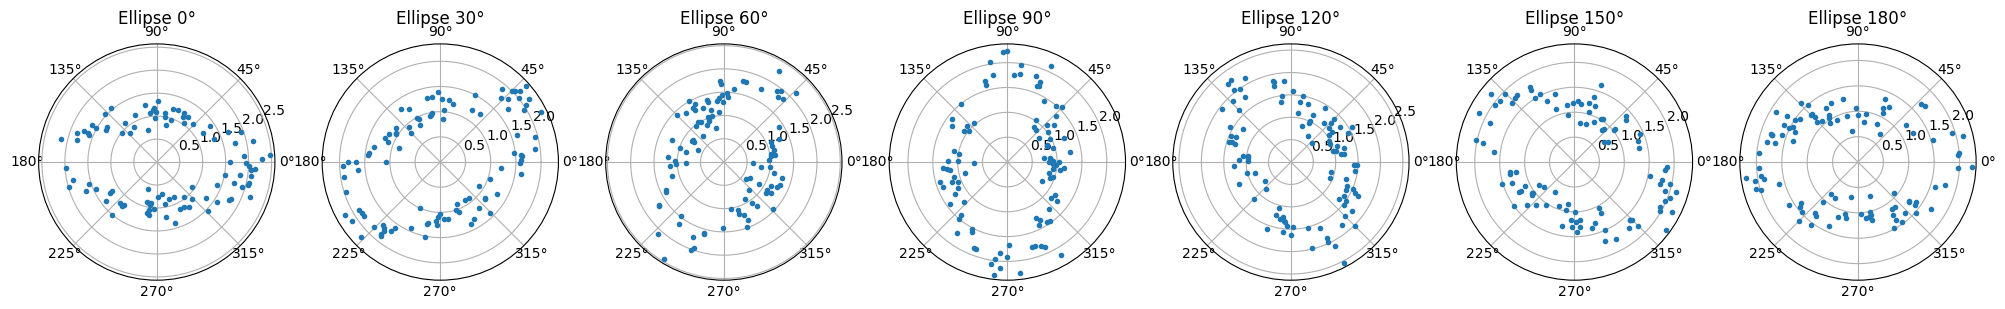

In [115]:
angles = [angle for angle in 0:π/6:π]
f1 = figure("Ellipses",figsize=(25,25))
for (i, angle) in enumerate(angles)
    data = generate_ellipse(2,1,angle,100,0.2)
    ax1 = subplot(1,length(angles),i, polar=true,)
    t = title(string("Ellipse ",(i-1)*30,"°"))
    pl1 = plot( data[:,1], data[:,2], linestyle="None", marker="." ) ;
    ax1[:set_theta_zero_location]("E") ;
end

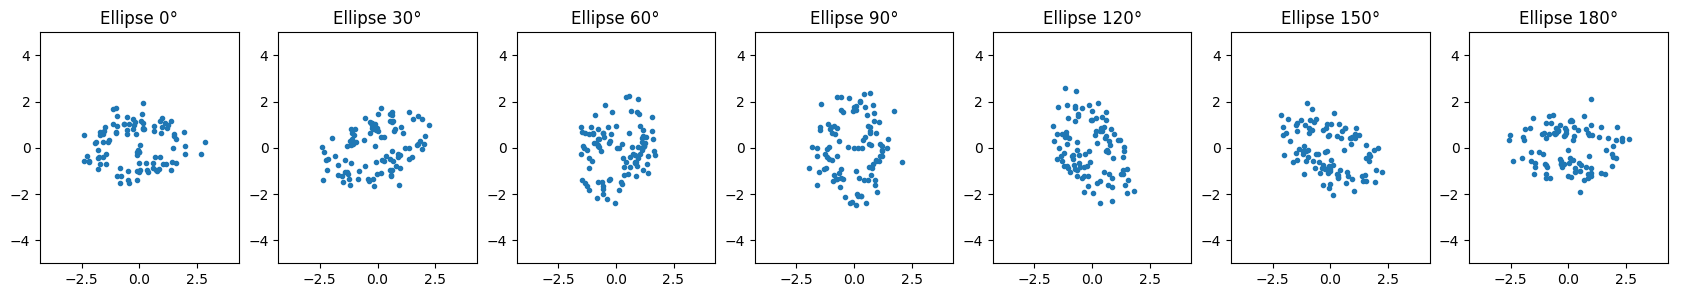

In [4]:
angles = [angle for angle in 0:π/6:π]
f1 = figure("Ellipses",figsize=(3*length(angles),3))
for (i, angle) in enumerate(angles)
    data = generate_parametric_ellipse(2,1,angle,100,0.4)
    ax1 = subplot(1,length(angles),i)
    t = title(string("Ellipse ",(i-1)*30,"°"))
    pl1 = plot( data[:,1], data[:,2], linestyle="None", marker="." ) ;
    axis("equal");
    ax1[:set_ylim]([-5,5])
    ax1[:set_xlim]([-5,5])
end

## Approximation of a Single Ellipse (No Noise)

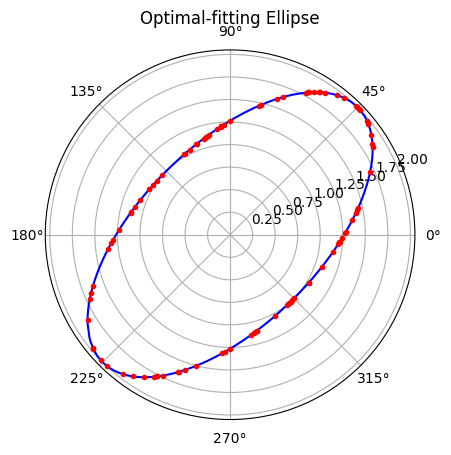

a = 2.000000000181084, b = 0.999999999962239, θ = 0.7853981634230737


In [95]:
#Create an ellipse dataset
datasize = 100
rawdata = generate_ellipse(2,1,π/4,datasize,0)
angles = vec(rawdata[:,1])
oradii = vec(rawdata[:,2])
no_noise_single_model = Model(solver=IpoptSolver(print_level=0))
@variable(no_noise_single_model, a>=0)
@variable(no_noise_single_model, b>=0)
@variable(no_noise_single_model, π>=θ>=0)
@constraint(no_noise_single_model, a >= b)
@NLexpression(no_noise_single_model, e[i=1:length(angles)],1/sqrt((cos(angles[i]-θ)/a)^2+(sin(θ-angles[i])/b)^2))
@NLobjective(no_noise_single_model, Min, sum((oradii[i]-e[i])^2 for i in 1:length(angles)))
setvalue(a, rand())
setvalue(b, rand())
setvalue(θ, π/2)
s = solve(no_noise_single_model)
opt_a = getvalue(a)
opt_b = getvalue(b)
opt_θ = getvalue(θ)
opt_e = getvalue(e)
println(string("a = ",opt_a, ", b = ",opt_b, ", θ = ",opt_θ))

optdata = generate_ellipse(opt_a,opt_b,opt_θ,500,0)
ax1 = subplot(1,1,1, polar=true,)
title("Optimal-fitting Ellipse")
po = plot( optdata[:,1], optdata[:,2], linestyle="-", marker="None",color="blue" ) ;
pr = plot( rawdata[:,1], rawdata[:,2], linestyle="None", marker=".",color="red") ;
ax1[:set_theta_zero_location]("E") ;

# Approximation of a Single Ellipse (0.3,0.5,0.7 Noise)

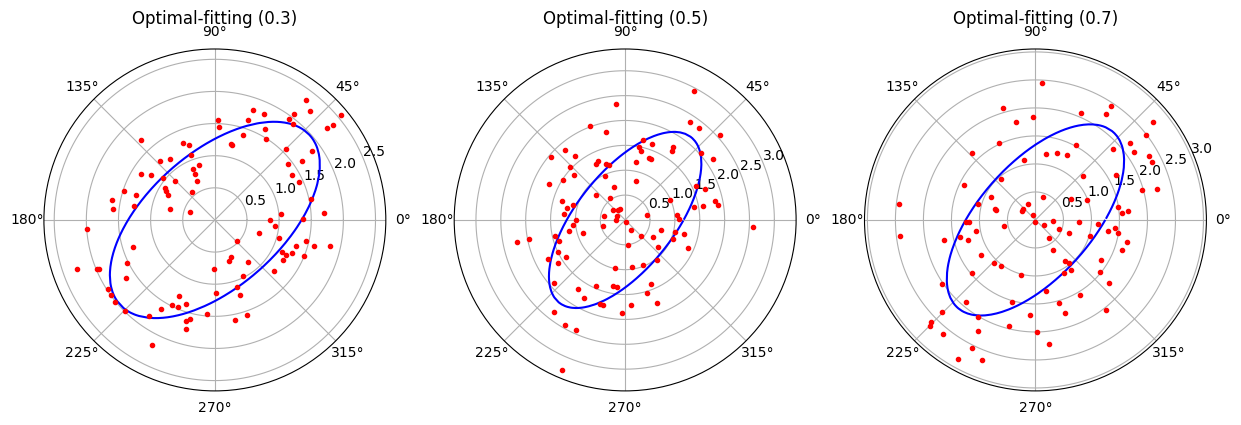

0.3: a = 1.9792503597351039, b = 1.0420567213672178, θ = 0.726048749921931
0.5: a = 2.12771245102459, b = 0.9783045560906867, θ = 0.8967161377037868
0.7: a = 2.094836484571731, b = 1.0151260720371804, θ = 0.8460346736021018


In [113]:
#Create an ellipse dataset
datasize = 100
rawdata_03 = generate_ellipse(2,1,π/4,datasize,0.3)
rawdata_05 = generate_ellipse(2,1,π/4,datasize,0.5)
rawdata_07 = generate_ellipse(2,1,π/4,datasize,0.7)
angles_03 = vec(rawdata_03[:,1])
oradii_03 = vec(rawdata_03[:,2])
angles_05 = vec(rawdata_05[:,1])
oradii_05 = vec(rawdata_05[:,2])
angles_07 = vec(rawdata_07[:,1])
oradii_07 = vec(rawdata_07[:,2])
noise_single_model_03 = Model(solver=IpoptSolver(print_level=0))
noise_single_model_05 = Model(solver=IpoptSolver(print_level=0))
noise_single_model_07 = Model(solver=IpoptSolver(print_level=0))
@variable(noise_single_model_03, a_03>=0)
@variable(noise_single_model_03, b_03>=0)
@variable(noise_single_model_03, π>=θ_03>=0)
@variable(noise_single_model_05, a_05>=0)
@variable(noise_single_model_05, b_05>=0)
@variable(noise_single_model_05, π>=θ_05>=0)
@variable(noise_single_model_07, a_07>=0)
@variable(noise_single_model_07, b_07>=0)
@variable(noise_single_model_07, π>=θ_07>=0)
#Specify that the a is the major axis
@constraint(noise_single_model_03, a_03 >= b_03)
@constraint(noise_single_model_05, a_05 >= b_05)
@constraint(noise_single_model_07, a_07 >= b_07)
@NLexpression(noise_single_model_03, e_03[i=1:length(angles_03)],1/sqrt((cos(angles_03[i]-θ_03)/a_03)^2+(sin(θ_03-angles_03[i])/b_03)^2))
@NLexpression(noise_single_model_05, e_05[i=1:length(angles_05)],1/sqrt((cos(angles_05[i]-θ_05)/a_05)^2+(sin(θ_05-angles_05[i])/b_05)^2))
@NLexpression(noise_single_model_07, e_07[i=1:length(angles_07)],1/sqrt((cos(angles_07[i]-θ_07)/a_07)^2+(sin(θ_07-angles_07[i])/b_07)^2))
@NLobjective(noise_single_model_03, Min, sum((oradii_03[i]-e_03[i])^2 for i in 1:length(angles_03)))
@NLobjective(noise_single_model_05, Min, sum((oradii_05[i]-e_05[i])^2 for i in 1:length(angles_05)))
@NLobjective(noise_single_model_07, Min, sum((oradii_07[i]-e_07[i])^2 for i in 1:length(angles_07)))
setvalue(a_03, rand())
setvalue(b_03, rand())
setvalue(θ_03, π/2)
setvalue(a_05, rand())
setvalue(b_05, rand())
setvalue(θ_05, π/2)
setvalue(a_07, rand())
setvalue(b_07, rand())
setvalue(θ_07, π/2)
s_03 = solve(noise_single_model_03)
s_05 = solve(noise_single_model_05)
s_07 = solve(noise_single_model_07)
opt_a_03 = getvalue(a_03)
opt_b_03 = getvalue(b_03)
opt_θ_03 = getvalue(θ_03)
opt_e_03 = getvalue(e_03)
opt_a_05 = getvalue(a_05)
opt_b_05 = getvalue(b_05)
opt_θ_05 = getvalue(θ_05)
opt_e_05 = getvalue(e_05)
opt_a_07 = getvalue(a_07)
opt_b_07 = getvalue(b_07)
opt_θ_07 = getvalue(θ_07)
opt_e_07 = getvalue(e_07)
println(string("0.3: a = ",opt_a_03, ", b = ",opt_b_03, ", θ = ",opt_θ_03))
println(string("0.5: a = ",opt_a_05, ", b = ",opt_b_05, ", θ = ",opt_θ_05))
println(string("0.7: a = ",opt_a_07, ", b = ",opt_b_07, ", θ = ",opt_θ_07))

optdata_03 = generate_ellipse(opt_a_03,opt_b_03,opt_θ_03,500,0)
optdata_05 = generate_ellipse(opt_a_05,opt_b_05,opt_θ_05,500,0)
optdata_07 = generate_ellipse(opt_a_07,opt_b_07,opt_θ_07,500,0)
f1 = figure("Ellipses",figsize=(15,15))
ax1 = subplot(1,3,1, polar=true,)
title("Optimal-fitting (0.3)")
po = plot( optdata_03[:,1], optdata_03[:,2], linestyle="-", marker="None",color="blue" ) ;
pr = plot( rawdata_03[:,1], rawdata_03[:,2], linestyle="None", marker=".",color="red") ;
ax1[:set_theta_zero_location]("E") ;
ax2 = subplot(1,3,2, polar=true,)
title("Optimal-fitting (0.5)")
po = plot( optdata_05[:,1], optdata_05[:,2], linestyle="-", marker="None",color="blue" ) ;
pr = plot( rawdata_05[:,1], rawdata_05[:,2], linestyle="None", marker=".",color="red") ;
ax2[:set_theta_zero_location]("E") ;
ax3 = subplot(1,3,3, polar=true,)
title("Optimal-fitting (0.7)")
po = plot( optdata_07[:,1], optdata_07[:,2], linestyle="-", marker="None",color="blue" ) ;
pr = plot( rawdata_07[:,1], rawdata_07[:,2], linestyle="None", marker=".",color="red") ;
ax3[:set_theta_zero_location]("E") ;

# Independent Approximation of a Set of Ellipses (No Noise)

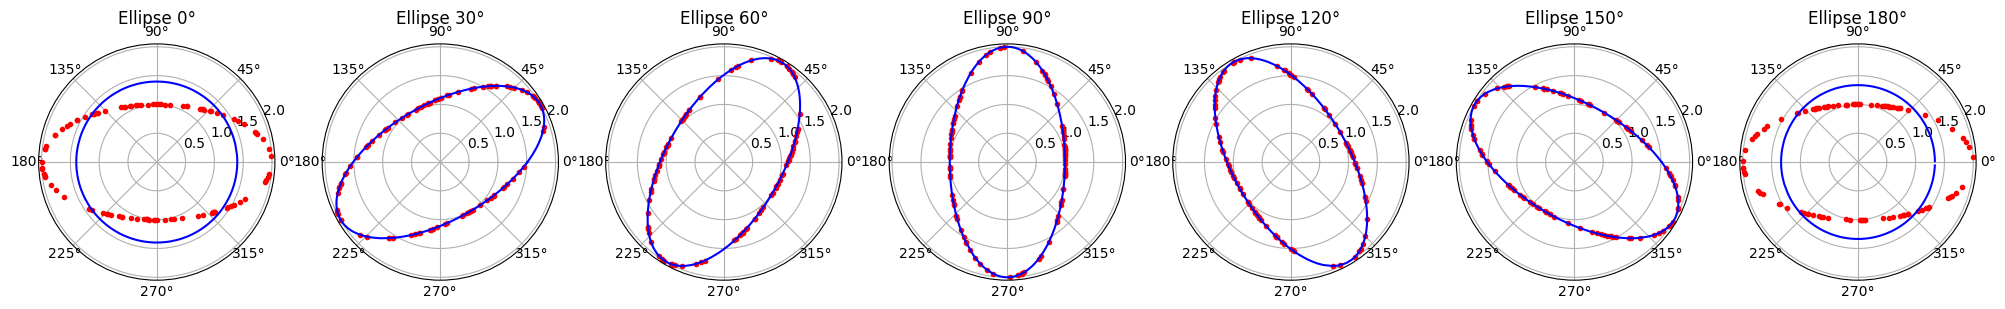

0.0: a = 1.3968693789446343, b = 1.3968693884624417, θ = 1.5463855244998088
0.5235987755982988: a = 2.0000000003949427, b = 0.9999999999198866, θ = 0.5235987757361618
1.0471975511965976: a = 2.000000000426297, b = 0.9999999999490099, θ = 1.047197551264471
1.5707963267948966: a = 2.000000000568142, b = 0.9999999999181188, θ = 1.5707963267922076
2.0943951023931953: a = 2.0000000005407195, b = 0.9999999999164118, θ = 2.094395102285065
2.617993877991494: a = 2.000000000448361, b = 0.9999999999037875, θ = 2.6179938778400977
3.141592653589793: a = 1.3345088248348531, b = 1.3345088343005334, θ = 1.5678091794783102


In [117]:
# Generate the Data
angles = collect(0:π/6:π)
ellipses = collect(1:length(angles))
datasize = 100
all_data = []

for (i, angle) in enumerate(angles)
    data = generate_ellipse(2,1,angle,datasize,0)
    if length(all_data) == 0
        all_data = data
    else
        all_data = cat(3, all_data, data)
    end
end
alldata = NamedArray(all_data, (collect(1:datasize),["Angle","Radius"],collect(1:length(angles))),("Degree","Measure","Ellipse"))

no_noise_multi_model = Model(solver=IpoptSolver(print_level=1))
@variable(no_noise_multi_model, a[ellipses] >= 0)
@variable(no_noise_multi_model, b[ellipses] >= 0)
@variable(no_noise_multi_model, π >= θ[ellipses] >= 0)
for ellipse in ellipses
    @constraint(no_noise_multi_model, a[ellipse] >= b[ellipse])
end
@NLexpression(no_noise_multi_model, est[i=1:datasize,j=1:length(ellipses)], 1/sqrt((cos(alldata[i,"Angle",j]-θ[j])/a[j])^2+(sin(θ[j]-alldata[i,"Angle",j])/b[j])^2))
@NLobjective(no_noise_multi_model, Min, sum(sum((alldata[i,"Radius",j] - est[i,j])^2 for i=1:datasize) for j=1:length(angles)))
for ellipse in ellipses
    setvalue(a[ellipse], rand())
    setvalue(b[ellipse], rand())
    setvalue(θ[ellipse], π/2)
end
s = solve(no_noise_multi_model)
opt_a = getvalue(a)
opt_b = getvalue(b)
opt_θ = getvalue(θ)
f1 = figure("Ellipses",figsize=(25,25))
for (i, angle) in enumerate(angles)
    ax1 = subplot(1,length(angles),i, polar=true,)
    t = title(string("Ellipse ",(i-1)*30,"°"))
    pl1 = plot( alldata[:,"Angle",i], alldata[:,"Radius",i], linestyle="None", marker=".",color="red") ;
    ax1[:set_theta_zero_location]("E") ;
    est_data = generate_ellipse(opt_a[i],opt_b[i],opt_θ[i],500,0)
    pl1 = plot( est_data[:,1], est_data[:,2], linestyle="-", marker="None",color="blue") ;
end
for (i, angle) in enumerate(angles)
    println(string(angle,": a = ",opt_a[i], ", b = ",opt_b[i], ", θ = ",opt_θ[i]))
end

$C = \begin{bmatrix}
0 & 0 & 2 & 0 & 0 & 0 \\
0 &-1 & 0 & 0 & 0 & 0 \\
2 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}$

$D = \begin{bmatrix}
x^2_1 & xy_1 & y^2_1 & x_1 & y_1 & 1_1 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x^2_n & xy_n & y^2_n & x_n & y_n & 1_n
\end{bmatrix}$

Model


$\begin{equation*}
\begin{aligned}
& \underset{a, \lambda}{\text{minimize}}
& & \left\lVert Da\right\rVert_2^2 \\
& \text{subject to}
& & a^TCa = 1\\
&&& (D^TD - \lambda C)a = 0\\
\end{aligned}
\end{equation*}$

In [164]:
# Create a constriant matrix to make sure the conic is an ellipse
C = [0  0 2 0 0 0
     0 -1 0 0 0 0
     2  0 0 0 0 0
     0  0 0 0 0 0
     0  0 0 0 0 0
     0  0 0 0 0 0]
I = [1 0 0 0 0 0
     0 1 0 0 0 0
     0 0 1 0 0 0
     0 0 0 1 0 0
     0 0 0 0 1 0
     0 0 0 0 0 1]

#Create an ellipse dataset
datasize = 100
rawdata = generate_parametric_ellipse(2,1,π/4,datasize,0)
x2 = vec([i*i for i in rawdata[:,1]])
y2 = vec([i*i for i in rawdata[:,2]])
x = vec(rawdata[:,1])
y = vec(rawdata[:,2])
xy = vec([rawdata[i,1]*rawdata[i,2] for i in 1:datasize])
o = vec(ones(datasize))
datamatrix = [x2 xy y2 x y o]
scattermatrix = transpose(datamatrix)*datamatrix
#print(string("Scatter Eigenvalues: ",eigs(scattermatrix, nev=5)[1],"\n"))
print(string("GEV: ",eigs(scattermatrix - C, sigma=.1),"\n"))
#print(string("C Eigenvalues: ",eigs(C, nev=5)[1],"\n"))

GEV: ([-0.433256,50.1887,73.1929,89.075,123.304],
[-0.409992 0.00231284 0.344495 0.612426 0.0884625; 0.482873 -0.675724 -0.382458 0.240791 -0.0287838; -0.410343 -0.0092525 -0.371623 -0.585074 -0.141828; -0.000844328 -0.382411 0.579894 -0.21087 -0.687574; 0.000598683 0.393475 -0.436092 0.392717 -0.705916; 0.656017 0.492185 0.265506 -0.161087 -0.0124815],

5,1,6,[0.0,0.0,0.0,0.0,0.0,0.0])
